In [1]:
import torch
import os
import numpy as np
from Hang.utils_u_groupnorm_pytorchLightning import *
from utils import *
import time as time
import nibabel as nib
import random
from tqdm import tqdm

np.random.seed(0)
random.seed(5)
torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
numbers = ["0001","0017","0018","0038","0040","0042","0046","0087","0090","0108","0116","0131","0178","0190",
           "0227","0248","0267","0282","0285","0398","0448","0466","0504","0514","0535","0564","0598","0606",
           "0607","0618","0620","0623","0642","0646","0655","0668","0675","0681","0719","0761","0762","0783",
           "0786","0868","0877","0887","0895","0902","0931","0979","1007","1013","1029","1033","1068","1142",
           "1143","1163","1190","1260","1275","1347","1383","1389","1416","1435","1441","1447","1451","1514",
           "1520","1602","1611","1621","1680","1684","1686","1710","1720","1739","1743","1749","1753","1760",
           "1795","1805","1845","1858","1876","1889","1892","1898","1899","1918","1924","1932","1952","1961",
           "1972","1987","2003","2007","2016","2020","2022","2030","2045","2047","2049","2053","2055","2074",
           "2077","2080","2091","2094","2103","2115","2128","2142","2144","2146","2152","2156","2158","2160",
           "2161","2179","2180","2181","2183","2186","2188","2212","2221","2231","2234","2245"]
SPLIT = 50
numbers = numbers[SPLIT + 25:]
SIM_BRAIN = '2245'
TYPE = '6'
SR = True

In [3]:
stats = np.load("stats_unet.npy") if SR else np.load("stats_no_sr.npy")

In [4]:
stats

array([[7.11421378, 4.20994112]])

1. 6 te w/SR ✅
2. 6 te w/o SR ✅
3. 32 te w/SR ✅

### Grab 256x256 brains

In [ ]:
fastt2_files, mask_files, lesion_mask_files = [], [], []
mwf_files = []

brain2245, label2245 = [], []
mask2245, lesion2245 = [], []

for number in numbers:
    file_root = "../" + number + "/"
    mask_files.append(file_root + "tightmask.nii.gz")
    lesion_mask_files.append(file_root + "lesion.nii.gz")
    if TYPE == '6':
        fastt2_files.append(file_root + "FASTT2_FULL.nii.gz")
    else:
        fastt2_files.append(file_root + "FASTT2_SNR_200_SIM.nii.gz")
    if SR:
        mwf_files.append(file_root + "MWF.nii.gz")
    else:
        mwf_files.append(file_root + "MWF_NO_SR.nii.gz")

mask_array, lesion_mask_array = [], []
brains, labels = [], []

for i in range(len(mask_files)):
    mask_array.append(nib.load(mask_files[i]).get_fdata())
    if (numbers[i] == '2245'):
        mask2245 = nib.load(mask_files[i]).get_fdata()[None]
    
for i in range(len(lesion_mask_files)):
    data = nib.load(lesion_mask_files[i]).get_fdata()
    data[data >= 1] = 1
    lesion_mask_array.append(data)
    if (numbers[i] == '2245'):
        lesion2245 = data[None]

for i in range(len(mask_files)):
    brain = nib.load(fastt2_files[i]).get_fdata().transpose((3,0,1,2)) * mask_array[i]
    brains.append(brain)
    if (numbers[i] == '2245'):
        cleanBrain = nib.load("../2245/FAST_T2_NO_NOISE.nii.gz").get_fdata()
        brain2245 = cleanBrain.transpose((3,0,1,2))[None]
        
for i in range(len(mask_files)):
    mwf = nib.load(mwf_files[i]).get_fdata() * mask_array[i]
    mwf = mwf[None]
    labels.append(mwf)
    if (numbers[i] == '2245'):
        label2245 = mwf[None]
    
# BIG NUMBER: n, num_features, 256, 256, 32

labels = np.array(labels)
brains = np.array(brains)
mask_array = np.array(mask_array)
lesion_mask_array = np.array(lesion_mask_array)

In [ ]:
from Hang.unet3dPersonalGroupNorm_pytorchLightning import unet3d

In [38]:
def calculateResultsErrorTable(state_dicts, stats, testBrains, testLabels, testMasks, numbers, lesions = None, 
                               save=False, brainType = "real", lesion = False):
    featureNumPaths = ["MWF"]
    for state_dict in state_dicts:
        model = unet3d(0.01, decay_factor = 0.2, n_classes = 1, in_channels = int(TYPE)).float()
        weight = state_dict.split("/")[-1].split(".")[0]
        state_dict = torch.load(state_dict, map_location='cpu')
        model.load_state_dict(state_dict["state_dict"])
        model = model.float().to(device)
        model.eval()
        results = {}
        results[0] = []
        size = testBrains.shape[2:] 
        part = ()
        
        for idx in range(len(testBrains)): 
            number = numbers[idx] if len(testBrains) == len(numbers) else 'average'
            mask = testMasks[idx]
            signal = np.divide(testBrains[idx], testBrains[idx][0] + 1e-16)[None]
            output = model(torch.tensor(signal).float().to(device)).to(device)
            label = testLabels[idx].copy()
            for i in range(len(stats)):
                output[0,i] *= stats[i][1]
                output[0,i] += stats[i][0]
            output = output.detach().cpu().numpy()
            
            label = np.nan_to_num(label).astype(float)
            output = np.nan_to_num(output).astype(float)
            output = output[0]
            
            for feature_num in range(len(label)):
                if (lesion):
                    lesionMask = lesions[idx]
                    if (lesionMask.sum() == 0):
                        continue
                    brain = np.zeros(output[0].shape, dtype=float)
                    label_big = np.zeros(output[0].shape, dtype=float)
                    min_val = -3000
                    max_val = 3000
                    if (feature_num == 0):
                        min_val = 0
                        max_val = 100
                    brain = np.clip(output[feature_num] * mask, min_val, max_val)
                    brain = brain * lesionMask
                    label_big = label[feature_num] * mask
                    label_big =  label_big * lesionMask
                    error = abs(-label_big+brain)
                    error = error[lesionMask == 1]
                    results[feature_num].append(np.mean(error))
                else:
                    brain = np.zeros(output[0].shape, dtype=float)
                    label_big = np.zeros(output[0].shape, dtype=float)
                    min_val = -3000
                    max_val = 3000
                    if (feature_num == 0):
                        min_val = 0
                        max_val = 100
                    brain = np.clip(output[feature_num] * mask, min_val, max_val)
                    label_big = label[feature_num] * mask
                    error = abs(-label_big+brain)
                    error = error[mask == 1]
                    results[feature_num].append(np.mean(error))
                    if (save):
                        brain = brain
                        label_big = label_big
                        brainT = np.zeros(size)
                        labelT = np.zeros(size)
                        brainT[part] = brain
                        labelT[part] = label_big
                        label_big = labelT
                        brain = brainT
                        base = f"results/0_weight_mwf/{featureNumPaths[feature_num]}/" if TYPE == '6' else f"results/unet_32_te/{featureNumPaths[feature_num]}/"
                        base = f"results/unet_no_sr/{featureNumPaths[feature_num]}/" if SR == False else base
                        sample = f"../{number}/MWF.nii.gz" if number != "average" else ""
                        save_nii(brain, base+f"{number}_pred_UNET_{brainType}.nii.gz", sample)
                        save_nii(label_big, base+f"{number}_label_UNET_{brainType}.nii.gz", sample)
                        save_nii(brain-label_big, base+f"{number}_err_UNET_{brainType}.nii.gz", sample)
    return results

### Simulation

In [ ]:
def generateBrains(cleanBrain, labels, masks, noise):
    brains = cleanBrain.copy()
    brains += noise
    for i in range(6):
        brains[:,i] *= masks
    return brains

### Reproducibility

#### Segmentation to mask

In [10]:
reproMaskFiles = []
reproFiles = []
reproMWFFiles = []

reproNumbers = ['125545', '093924', '151026', '111721', '093923', '151025', '113308', '113307', '171732', '101851', 
                '125546', '163835', '163834', '154655', '101850', '175630', '175631', '184052', '111720', '184051']
for number in reproNumbers:
    file_root = "../" + number + "/"
    reproMaskFiles.append(file_root + "tightmask.nii.gz")
    reproFiles.append(file_root + "FASTT2_FULL.nii.gz")
    reproMWFFiles.append(file_root + "MWF.nii.gz")

reproMasks = []
reproBrains = []
reproMWFs = []
for mask in reproMaskFiles:
    mask = nib.load(mask).get_fdata()
    reproMasks.append(mask)

for file_idx in range(len(reproFiles)):
    file = reproFiles[file_idx]
    brain = nib.load(file).get_fdata().transpose((3,0,1,2)) * reproMasks[file_idx]
    reproBrains.append(brain)
    
for img in reproMWFFiles:
    img = nib.load(img).get_fdata()
    reproMWFs.append(img[None])

reproMasks = np.array(reproMasks)
reproBrains = np.array(reproBrains)
reproMWFs = np.array(reproMWFs)

### Save 256x256 test brains

In [9]:
from scipy.stats import ttest_ind

In [10]:
state_dicts = []
if SR:
    if TYPE == '6':
        state_dicts = ["../unet_models/unet_model_epoch_15.ckpt"]
    else:
        state_dicts = ["../unet_models/unet_model_epoch_40_32_te.ckpt"]
else:
    state_dicts = ["../unet_models/unet_no_sr_epoch_56.ckpt"]

In [60]:
res256 = calculateResultsErrorTable(state_dicts, stats, brains, labels, mask_array, numbers, save=True, 
                                    brainType='256real')

In [61]:
print(np.mean(res256[0]), np.std(res256[0])) #MAE for L2

1.2638133009908636 0.1940409834314364


In [62]:
res256Lesion = calculateResultsErrorTable(state_dicts, stats, brains, labels, mask_array, numbers, lesion_mask_array,
                                          lesion = True)

In [63]:
print(np.mean(res256Lesion[0]), np.std(res256Lesion[0])) #MAE for L2

1.4081707483598058 0.39757676647296625


### Save 256x256 simulation

#### Simulate brain 1260 in 256x256 space

In [16]:
res256snr200 = []
res256snr200Lesion = []
res256snr100 = []
res256snr100Lesion = []
res256snr50 = []
res256snr50Lesion = []
res256snr25 = []
res256snr25Lesion = []

minSum200 = 10000
minSum100 = 10000
minSum50 = 10000
minSum25 = 10000

for i in tqdm(range(500)):
    '''Generating Brain'''
    NUM_BRAINS = len(brain2245)
    SNR = 200
    roi = load_nii("roi.nii.gz")
    noise = np.random.normal(size=(NUM_BRAINS,) + label2245[0].shape, scale=(brain2245[0,0][roi == 1].mean()/SNR))
    simBrains256_snr200 = generateBrains(brain2245, label2245, mask2245, noise)
    SNR = 100
    noise = np.random.normal(size=(NUM_BRAINS,) + label2245[0].shape, scale=(brain2245[0,0][roi == 1].mean()/SNR))
    simBrains256_snr100 = generateBrains(brain2245, label2245, mask2245, noise)
    SNR = 50
    noise = np.random.normal(size=(NUM_BRAINS,) + label2245[0].shape, scale=(brain2245[0,0][roi == 1].mean()/SNR))
    simBrains256_snr50 = generateBrains(brain2245, label2245, mask2245, noise)
    SNR = 25
    noise = np.random.normal(size=(NUM_BRAINS,) + label2245[0].shape, scale=(brain2245[0,0][roi == 1].mean()/SNR))
    simBrains256_snr25 = generateBrains(brain2245, label2245, mask2245, noise)
    
    '''Testing Brain'''
    tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr200, label2245, mask2245, [SIM_BRAIN], 
                                         save=False, brainType='256sim_snr200')
    tempResLesion = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr200, label2245, mask2245, 
                                               [SIM_BRAIN], lesion2245, save=False, lesion=True)
    res256snr200.append(tempRes)
    res256snr200Lesion.append(tempResLesion)
    if (sum(tempRes) < minSum200):
        minSum200 = sum(tempRes)
        tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr200, label2245, mask2245, [SIM_BRAIN], 
                                             save=True, brainType='256sim_snr200')

    tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr100, label2245, mask2245, [SIM_BRAIN], 
                                         save=False, brainType='256sim_snr100')
    tempResLesion = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr100, label2245, mask2245, 
                                               [SIM_BRAIN], lesion2245, save=False, lesion=True)
    res256snr100.append(tempRes)
    res256snr100Lesion.append(tempResLesion)
    if (sum(tempRes) < minSum100):
        minSum100 = sum(tempRes)
        tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr100, label2245, mask2245, [SIM_BRAIN], 
                                             save=True, brainType='256sim_snr100')
        
    tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr50, label2245, mask2245, [SIM_BRAIN], 
                                         save=False, brainType='256sim_snr50')
    tempResLesion = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr50, label2245, mask2245, 
                                         [SIM_BRAIN], lesion2245,  save=False, lesion=True)
    res256snr50.append(tempRes)
    res256snr50Lesion.append(tempResLesion)
    if (sum(tempRes) < minSum50):
        minSum50 = sum(tempRes)
        tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr50, label2245, mask2245, [SIM_BRAIN], 
                                             save=True, brainType='256sim_snr50')
        
    tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr25, label2245, mask2245, [SIM_BRAIN], 
                                         save=False, brainType='256sim_snr25')
    tempResLesion = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr25, label2245, mask2245, 
                                         [SIM_BRAIN], lesion2245,  save=False, lesion=True)
    res256snr25.append(tempRes)
    res256snr25Lesion.append(tempResLesion)
    if (sum(tempRes) < minSum25):
        minSum25 = sum(tempRes)
        tempRes = calculateResultsErrorTable(state_dicts, stats, simBrains256_snr25, label2245, mask2245, [SIM_BRAIN], 
                                             save=True, brainType='256sim_snr25')

100%|██████████| 500/500 [31:40<00:00,  3.80s/it]


In [17]:
res256snr200Avg = compressResults(res256snr200)
res256snr100Avg = compressResults(res256snr100)
res256snr50Avg = compressResults(res256snr50)
res256snr25Avg = compressResults(res256snr25)

res256snr200LesionAvg = compressResults(res256snr200Lesion)
res256snr100LesionAvg = compressResults(res256snr100Lesion)
res256snr50LesionAvg = compressResults(res256snr50Lesion)
res256snr25LesionAvg = compressResults(res256snr25Lesion)

In [18]:
simData = [res256snr200, res256snr100, res256snr50, res256snr25]
simDataLesion = [res256snr200Lesion, res256snr100Lesion, res256snr50Lesion, res256snr25Lesion]

In [21]:
res256snr25LesionAvg

({0: array([0.51679269])}, {0: array([0.00656252])})

### Simulating on different Echo Times

In [25]:
maskNewTE = nib.load("../2245/tightmask.nii.gz").get_fdata()[None]
labelNewTE = nib.load("../2245/MWF.nii.gz").get_fdata()[None][None]

In [26]:
brainsNewTE = nib.load("../2245/FASTT2_SNR_200_SIM_NEW_TE.nii.gz").get_fdata().transpose((3,0,1,2)) * mask_array[0]
brainsNewTE = brainsNewTE[None]

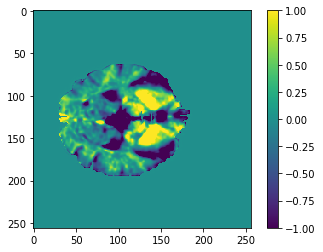

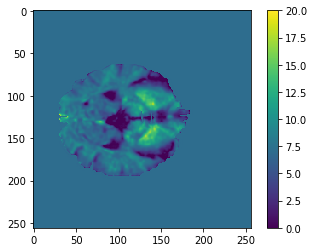

In [39]:
resSim = calculateResultsErrorTable(state_dicts, stats, brainsNewTE, labelNewTE , maskNewTE, ["2245"], 
                                      save=True, brainType='new_te')

In [35]:
resSim

{0: [2.7536310774347093]}

### Save Repro

In [22]:
resRepro = calculateResultsErrorTable(state_dicts, stats, reproBrains, reproMWFs, reproMasks, reproNumbers, 
                                      save=True, brainType='repro')

In [23]:
print(np.mean(resRepro[0]), np.std(resRepro[0])) #MAE for L2

0.6759005305916704 0.2624753626683109


### Saving Results

In [64]:
if SR:
    if TYPE == '6':
        np.save("unetData.npy", [res256, res256Lesion, 
                                 res256snr200Avg, res256snr100Avg, res256snr50Avg, res256snr25Avg,
                                 res256snr200LesionAvg, res256snr100LesionAvg, res256snr50LesionAvg, 
                                 res256snr25LesionAvg, resRepro, simData, simDataLesion], allow_pickle=True)
    else:
        np.save("unetData_32_te.npy", [res256, res256Lesion], allow_pickle=True)
else:
    np.save("unetData_no_sr.npy", [res256, res256Lesion], allow_pickle=True)